# 1-0. Import

In [1]:
import os.path as osp
import openslide
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.filters import threshold_otsu

from openslide.deepzoom import DeepZoomGenerator

import cv2
from keras.utils.np_utils import to_categorical

# network

from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

# train

from sklearn.model_selection import StratifiedShuffleSplit
from datetime import datetime

# evaluate

import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

Using TensorFlow backend.


# 1-1. Data Load

In [2]:
slide_path = 'data/train/image/positive/Slide001.mrxs'
slide = openslide.open_slide(slide_path)

BASE_TRUTH_DIR = Path('data/train/mask')
truth_path = str(BASE_TRUTH_DIR/'positive/Slide001.png')
truth = openslide.open_slide(truth_path)

print("original slide dimensions %dx%d" % slide.dimensions)
print("original truth dimensions %dx%d" % truth.dimensions)

original slide dimensions 93970x234042
original truth dimensions 5316x10007


# 1-2. Fit Data Shape

- 밑에 a, b 괄호친 부분은 csv 파일 읽고 min_x, min_y 넣어야함

- https://openslide.org/api/python/#module-openslide


In [3]:
PATCH_SIZE = 256

In [5]:
a = 7744  # min x offset  
b = 39056   # min y offset
start = (int(a),int(b)) 
c, d = (truth.dimensions[0]/16,truth.dimensions[1]/16)
size = (int(c),int(d))
level = np.log2(PATCH_SIZE)
level = int(level)
slide4 = slide.read_region(start,level,size) # 3초 #read_region(location, level, size)

In [8]:
thumbnail_truth = truth.get_thumbnail((truth.dimensions[0]/16 , truth.dimensions[1]/16 )) 

In [9]:
print('slide4_size : ',slide4.size)
print('truth_size : ', thumbnail_truth.size)

print('slide4_type : ',type(slide4),', truth_shape : ',type(thumbnail_truth))

slide4_size :  (332, 625)
truth_size :  (332, 625)
slide4_type :  <class 'PIL.Image.Image'> , truth_shape :  <class 'PIL.Image.Image'>


## Check if works

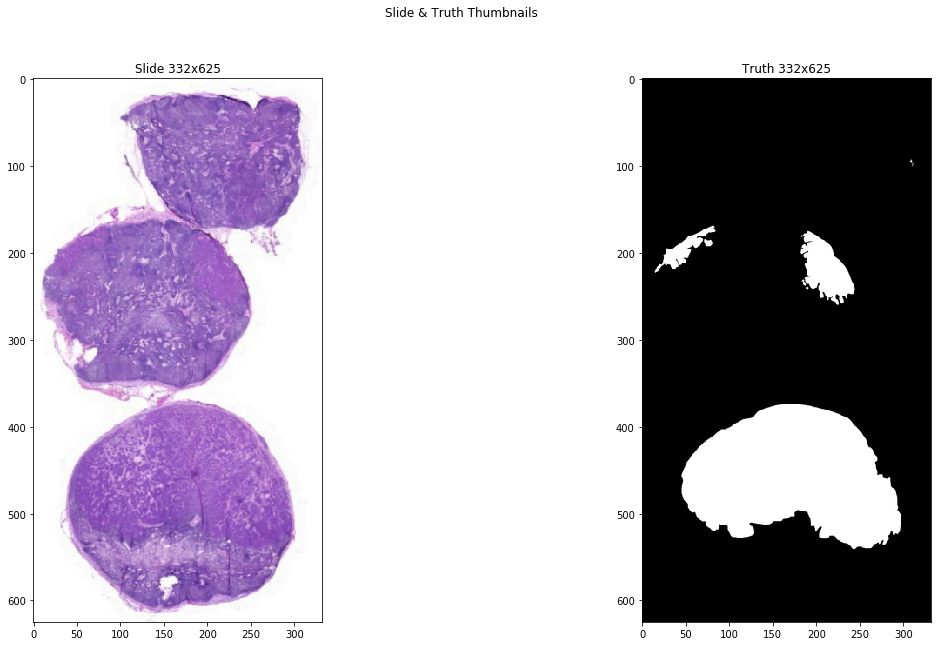

In [10]:

f, axes = plt.subplots(1, 2, figsize=(20, 10));
ax = axes.ravel()
ax[0].imshow(slide4);
ax[0].set_title('Slide %dx%d' % slide4.size)
ax[1].imshow(thumbnail_truth.convert('L'), cmap='gray');
ax[1].set_title('Truth %dx%d' % thumbnail_truth.size)
f.suptitle('Slide & Truth Thumbnails ');

# 1-3 Patch Gen

- get_thumbnail(size)
: Return an Image containing an RGB thumbnail of the slide.
- patch size 만큼 dimensions 나누기. 1 픽셀이 하나의 패치가 됨 -> DeepZoomGenerator로 다시 확대가능 (patch_size만큼) (2의 거듭제곱으로)
- tissue 검사 - patch['is_tissue'] : ostu method
- tumor 검사 - patch['is_tummor'] 라벨 : mask로 구분
- 경로 추가 저장 = patch['slide_path']
- 최종 training set = concat[patch, patch_y]

In [120]:
PATCH_SIZE = 256
IS_TRAIN = True

## Patch Gen Check 

b

In [17]:
slide_contains_tumor = 'pos' in slide_path

truth_div = PATCH_SIZE/16 # PATCHSIZE = 256, truth_mask 는 원본(최고 높은 레벨)의 1/16. 따라서 맞춰줄 크기는 /16만 더하면됨
truth_div = int(truth_div)
slide4_grey = np.array(slide4.convert('L'))
thresh = threshold_otsu(slide4_grey)
binary = slide4_grey > thresh
patches = pd.DataFrame(pd.DataFrame(binary).stack())
patches['is_tissue'] = patches[0]
patches.drop(0, axis=1,inplace =True)
patches['slide_path'] = slide_path

print('# tissues in patches : ',len(patches[patches.is_tissue>0]))    

# tissues in patches :  151213


In [21]:
if slide_contains_tumor:
    thumbnail_truth = truth.get_thumbnail((truth.dimensions[0] / truth_div, truth.dimensions[1] / truth_div)) 
    print('type thumbnail_truth, ',type(thumbnail_truth))
    patches_y = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())
    patches_y['is_tumor'] = patches_y[0] > 0
    patches_y.drop(0, axis=1, inplace=True)
    samples = pd.concat([patches, patches_y], axis=1)


type thumbnail_truth,  <class 'PIL.Image.Image'>


In [24]:
print('tumor patches # : ', len(patches_y[patches_y.is_tumor>0]))

tumor patches # :  35179


In [26]:
samples = pd.concat([patches, patches_y], axis=1)
len(samples)

207500

In [27]:
samples = samples[samples.is_tissue == True] # remove patches with no tissue
print('only tissue samples len : ',len(samples))

only tissue samples len :  151213


In [28]:
samples.head(3)

is_tissue                               slide_path  is_tumor
0 141       True  data/train/image/positive/Slide001.mrxs     False
  142       True  data/train/image/positive/Slide001.mrxs     False
  143       True  data/train/image/positive/Slide001.mrxs     False

In [29]:
samples['tile_loc'] = list(samples.index)
samples.reset_index(inplace=True, drop=True)

In [30]:
samples.head(3)

,is_tissue,slide_path,is_tumor,tile_loc
0,True,data/train/image/positive/Slide001.mrxs,False,"(0, 141)"
1,True,data/train/image/positive/Slide001.mrxs,False,"(0, 142)"
2,True,data/train/image/positive/Slide001.mrxs,False,"(0, 143)"


In [31]:
samples.is_tumor.value_counts()  

# 비율도 통계로 내려봐야할듯 나중에 샘플링할때 

False    116060
True      35153
Name: is_tumor, dtype: int64

In [32]:
samples.is_tissue.value_counts()

True    151213
Name: is_tissue, dtype: int64

## Check if works - slide_tile_loc, 

In [33]:
start

(7744, 39056)

In [34]:
tiles = DeepZoomGenerator(slide,tile_size=256, overlap=0 ,limit_bounds = False)
tiles_truth = DeepZoomGenerator(truth, tile_size=16, overlap = 0, limit_bounds = False)

In [36]:
print('tile, truth level # : ',tiles.level_count,
tiles_truth.level_count)

tile, truth level # :  19 15


In [37]:
tiles.level_dimensions[18]

(93970, 234042)

In [54]:
tiles.tile_count
tiles_truth.level_tiles[14]

(333, 626)

In [56]:
tiles.level_tiles[18]

(368, 915)

In [40]:
tiles.level_dimensions[10]

(368, 915)

In [41]:
tiles_truth.level_dimensions[10]

(333, 626)

In [35]:
samples[samples.is_tumor>0].head(5)

,is_tissue,slide_path,is_tumor,tile_loc
20549,True,data/train/image/positive/Slide001.mrxs,True,"(92, 308)"
20550,True,data/train/image/positive/Slide001.mrxs,True,"(92, 309)"
20551,True,data/train/image/positive/Slide001.mrxs,True,"(92, 310)"
20785,True,data/train/image/positive/Slide001.mrxs,True,"(93, 306)"
20787,True,data/train/image/positive/Slide001.mrxs,True,"(93, 308)"


In [64]:
thumbnail_truth.size

(332, 625)

In [68]:
 k = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())

In [72]:
k['tile_loc'] = list(k.index)
k.reset_index(inplace=True, drop=True) # tile_loc 은 x,y가 거꾸로 들어감 (height, width) 정보라고 보면됨 (y,x)로 들어감

In [77]:
k = k[k[0]>0]

In [78]:
k

,0,tile_loc
30852,3,"(92, 308)"
30853,3,"(92, 309)"
30854,1,"(92, 310)"
31182,1,"(93, 306)"
31184,20,"(93, 308)"
31185,73,"(93, 309)"
31187,3,"(93, 311)"
31514,1,"(94, 306)"
31515,1,"(94, 307)"
31516,88,"(94, 308)"


Text(0.5, 1.0, 'Truth mask (white=tumor, black=not_tumor)')

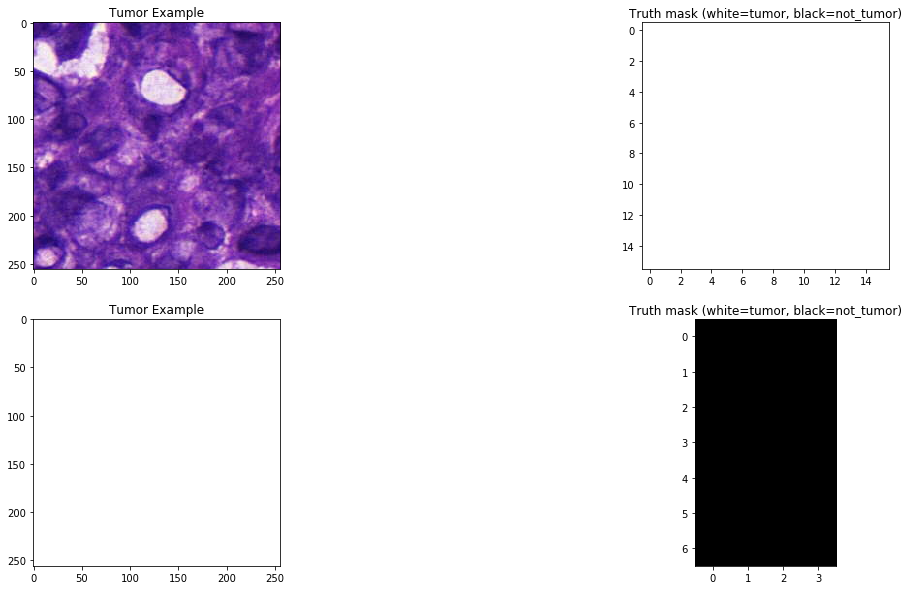

In [105]:
f, axes = plt.subplots(2, 2, figsize=(20, 10))
axes[0, 0].imshow(tiles.get_tile(tiles.level_count-1, (339, 247))); # turth에서 x는 30만큼, y는 152만큼 더해줘야함
axes[0, 0].set_title('Tumor Example');
axes[0, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1,(309,95)));
axes[0, 1].set_title('Truth mask (white=tumor, black=not_tumor)')

axes[1, 0].imshow(tiles.get_tile(tiles.level_count-1, (362, 777)));
axes[1, 0].set_title('Tumor Example');
axes[1, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1,(332,625))); # turth 끝 경계
axes[1, 1].set_title('Truth mask (white=tumor, black=not_tumor)')

In [324]:
thumbnail = slide.read_region(start,8,size)

In [327]:
type(tiles)

openslide.deepzoom.DeepZoomGenerator

In [331]:
tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
tiles_truth = DeepZoomGenerator(truth, tile_size=16, overlap=0, limit_bounds=False)

AttributeError: 'Image' object has no attribute 'level_dimensions'

In [332]:
tiles_truth.level_count-1

14

# 1-4. Train data Gen

In [114]:
NUM_CLASSES = 2 # not_tumor, tumor

def gen_imgs(samples, batch_size, base_truth_dir=BASE_TRUTH_DIR, shuffle=True):
    """This function returns a generator that 
    yields tuples of (
        X: tensor, float - [batch_size, 256, 256, 3]
        y: tensor, int32 - [batch_size, 256, 256, NUM_CLASSES]
    )
    
    
    input: samples: samples dataframe
    input: batch_size: The number of images to return for each pull
    output: yield (X_train, y_train): generator of X, y tensors
    
    option: base_truth_dir: path, directory of truth slides
    option: shuffle: bool, if True shuffle samples
    """
    
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        if shuffle:
            samples = samples.sample(frac=1) # shuffle samples
        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
        
            images = []
            masks = []
            for _, batch_sample in batch_samples.iterrows():
                slide_contains_tumor = 'pos' in slide_path
                
                with openslide.open_slide(batch_sample.slide_path) as slide:
                     
                    tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
                    
                    # 여기서 틀렸네
                    x, y = batch_sample.tile_loc[::-1]
                    x += 30
                    y += 152
                    img = tiles.get_tile(tiles.level_count-1, (x,y))
                    
                # only load truth mask for tumor slides
                if slide_contains_tumor:
                    truth_path = str(base_truth_dir/'positive/Slide001.png')
                    with openslide.open_slide(truth_path) as truth:
                        truth_tiles = DeepZoomGenerator(truth, tile_size=16, overlap=0, limit_bounds=False)
                        mask = truth_tiles.get_tile(truth_tiles.level_count-1, batch_sample.tile_loc[::-1])
                        mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                else:
                    mask = np.zeros((256, 256))

                images.append(np.array(img))
                masks.append(mask)

            X_train = np.array(images)
            y_train = np.array(masks)
            print('x_train_shape :', X_train.shape)
            print('y_train_shape : ',y_train.shape)
            y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], 16, 16, 2) # 이부분 증가시켜줘야하는데
            yield X_train, y_train

In [115]:
sample_gen = gen_imgs(samples.sample(10, random_state=13), 10, shuffle=False)
%time example_X, example_y  = next(sample_gen)

x_train_shape : (10, 256, 256, 3)
y_train_shape :  (10, 16, 16)
Wall time: 6.43 s


In [279]:
%time example_X, example_y  = next(sample_gen)

Wall time: 15.9 s


## Check if right

In [116]:
example_X.shape

(10, 256, 256, 3)

In [117]:
example_y.shape

(10, 16, 16, 2)

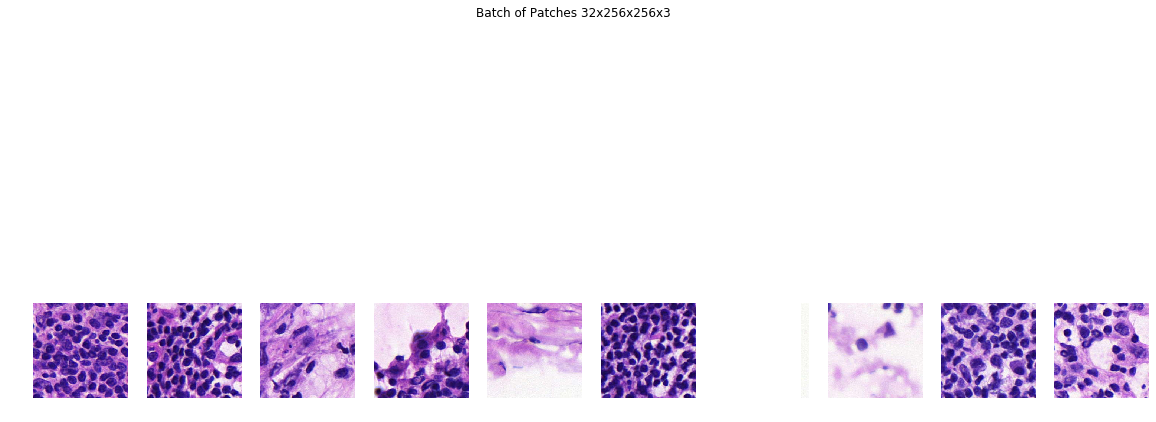

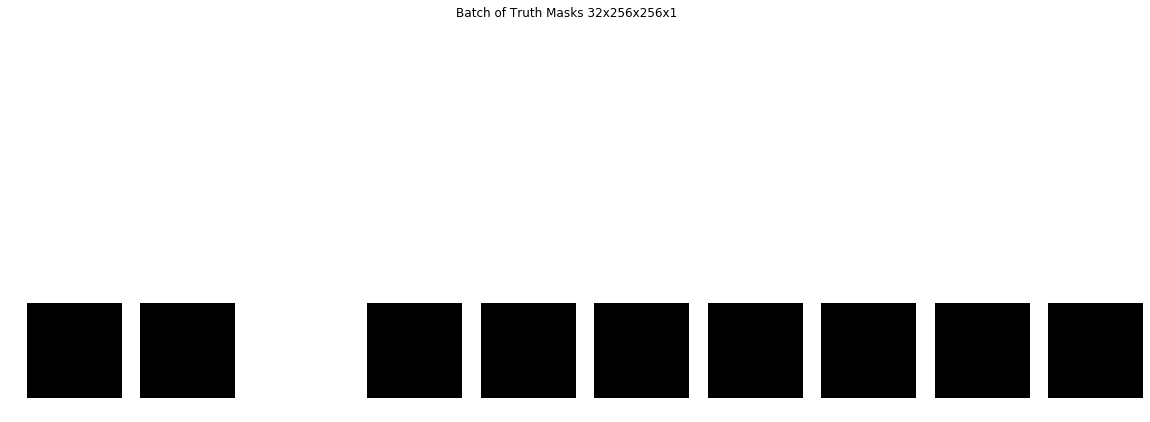

In [119]:
f, axes = plt.subplots(1,10, figsize=(20, 10));
ax = axes.flatten()
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_X[i]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32x256x256x3');
    
f, axes = plt.subplots(1, 10, figsize=(20, 10));
ax = axes.flatten()    
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('Batch of Truth Masks 32x256x256x1');